In [22]:
using Pkg
Pkg.develop("QuantumDots")
Pkg.activate(pwd())
Pkg.instantiate()
using QuantumDots
using LinearAlgebra
using Plots
using DifferentialEquations

   Resolving package versions...
  No Changes to `C:\Users\vi2823sv\.julia\dev\QuantumDots\examples\Project.toml`
  No Changes to `C:\Users\vi2823sv\.julia\dev\QuantumDots\examples\Manifest.toml`
  Activating project at `c:\Users\vi2823sv\.julia\dev\QuantumDots\examples`


In [23]:
struct MajoranaWrapper{B,D}
    basis::B
    majoranas::D
    function MajoranaWrapper(basis, labels=collect(Base.product(keys(basis), (:a, :b))))
        N = length(basis)
        length(labels) == 2 * N || throw(ErrorException("Number of majoranas is not twice the fermion number"))
        majA = map(f -> f + f', basis)
        majB = map(f -> 1im * (f - f'), basis)
        majs = vcat(majA, majB)
        dA = QuantumDots.dictionary(zip(labels[1:N], values(majA)))
        dB = QuantumDots.dictionary(zip(labels[N+1:2N], values(majB)))
        d = merge(dA, dB)
        new{typeof(basis),typeof(d)}(basis, d)
    end
end
Base.getindex(g::MajoranaWrapper, i...) = g.majoranas[i...]

In [24]:
c = FermionBasis(1:2)
majorana_labels = 0:3
γ = MajoranaWrapper(c, majorana_labels)

MajoranaWrapper{FermionBasis{2, Int64, SparseArrays.SparseMatrixCSC{Int64, Int64}, QuantumDots.NoSymmetry}, Dictionaries.Dictionary{Int64, SparseArrays.SparseMatrixCSC{T, Int64} where T}}(FermionBasis{2,Int64,SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.NoSymmetry}:
keys = {1, 2}, {0 = sparse([2, 1, 4, 3], [1, 2, 3, 4], [1, 1, -1, -1], 4, 4), 1 = sparse([3, 4, 1, 2], [1, 2, 3, 4], [1, 1, 1, 1], 4, 4), 2 = sparse([2, 1, 4, 3], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 + 1im, 0 + 1im, 0 - 1im], 4, 4), 3 = sparse([3, 4, 1, 2], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 - 1im, 0 + 1im, 0 + 1im], 4, 4)})

In [25]:
smooth_step(x, k) = 1 / 2 + tanh(k * x) / 2
# Give the value of the three deltas at time t in the three point majorana braiding protocol
function braiding_deltas(t, T, Δmax, Δmin, k, args...)
    Δ1 = Δtrajectory(t, T, Δmax, Δmin, k)
    Δ2 = Δtrajectory(t + T / 3, T, Δmax, Δmin, k)
    Δ3 = Δtrajectory(t + 2T / 3, T, Δmax, Δmin, k)
    return Δ1, Δ2, Δ3
end
function Δtrajectory(t, T, Δmax, Δmin, k, args...)
    dΔ = Δmax - Δmin
    tp = mod(t, T) - T / 12
    Δmin + dΔ * smooth_step(tp - 1T / 6, k) - dΔ * smooth_step(tp - 4T / 6, k)
end

Δtrajectory (generic function with 1 method)

In [ ]:
const γ01 = Matrix(1.0im * γ[0] * γ[1])
const γ02 = Matrix(1.0im * γ[0] * γ[2])
const γ03 = Matrix(1.0im * γ[0] * γ[3])
const Ps = (γ01, γ02, γ03);

In [27]:
function H((T, Δmin, Δmax, k), t)
    Δs = braiding_deltas(t, T, Δmax, Δmin, k)
    sum(Δ * P for (Δ, P) in zip(Δs, Ps))
end
function drho!(du, u, p, t)
    ham = H(p, t)
    mul!(du, ham, u, 1im, 0)
    return du
end

drho! (generic function with 1 method)

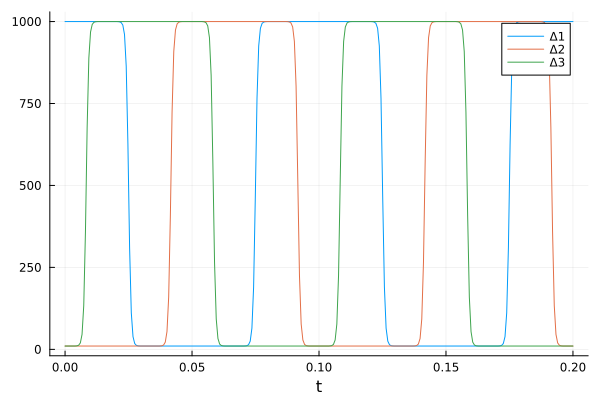

In [28]:
vacuumvec = zeros(ComplexF64, size(γ01, 1))
vacuumvec[1] = 1
u0 = vacuumvec # Initial state
u0 = u0 / norm(u0)
T = 0.1
k = 100 / T
Δmax = 1e2 / T
Δmin = Δmax * 1e-2
σ = Δmax / 10
p = (T, Δmin, Δmax, k)
tspan = (0.0, 2T)

prob = ODEProblem(drho!, u0, tspan, p)
ts = range(0, tspan[2], 300)
deltas = stack([braiding_deltas(t, p...) for t in ts])'
plot(ts, deltas, label=["Δ1" "Δ2" "Δ3"], xlabel="t")

  0.003533 seconds (24.26 k allocations: 5.563 MiB)


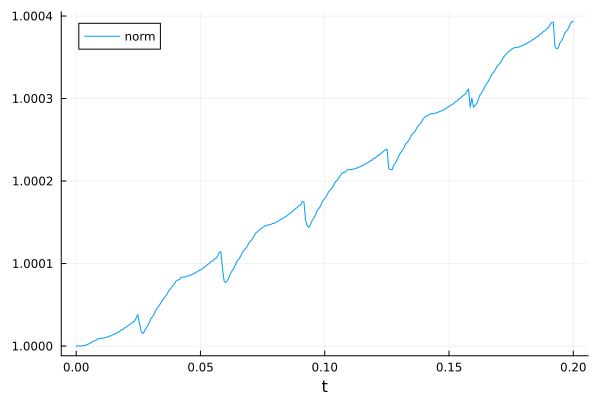

In [32]:
@time sol = solve(prob, saveat=ts)
plot(ts, map(norm, sol), label="norm", xlabel="t")

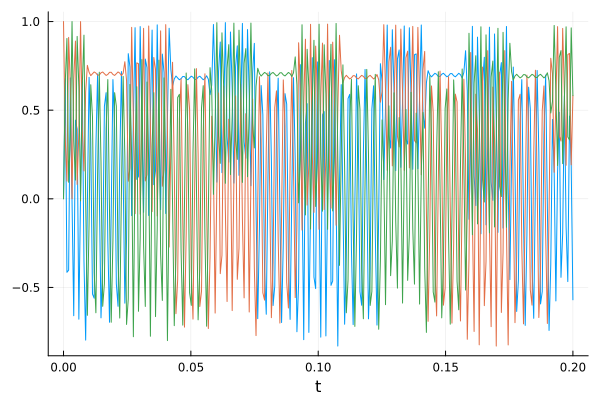

In [30]:
#lets measure the parities
measurements = Ps
plot(ts, [real(sol(t)'m * sol(t)) for m in measurements, t in ts]', legend=false, xlabel="t")